In [16]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

pd.options.display.max_rows = 8
pd.options.display.max_columns = 200

RANDOM_STATE = 42


HAS_XGB = False


In [17]:
BASE_DIR = "data"

PATH_TRAIN       = os.path.join(BASE_DIR, "train.csv")
PATH_TEST        = os.path.join(BASE_DIR, "test.csv")
PATH_CLIENTS     = os.path.join(BASE_DIR, "clients2.csv")
PATH_PRODUCTS    = os.path.join(BASE_DIR, "products.csv")
PATH_TRAIN_PURCH = os.path.join(BASE_DIR, "train_purch.csv")
PATH_TEST_PURCH  = os.path.join(BASE_DIR, "test_purch.csv")

paths = [PATH_TRAIN, PATH_TEST, PATH_CLIENTS, PATH_PRODUCTS, PATH_TRAIN_PURCH, PATH_TEST_PURCH]
for p in paths:
    print(p, "exists:", os.path.exists(p))


data/train.csv exists: True
data/test.csv exists: True
data/clients2.csv exists: True
data/products.csv exists: True
data/train_purch.csv exists: True
data/test_purch.csv exists: True


In [18]:
train = pd.read_csv(PATH_TRAIN, dtype={"client_id": "string"})
test  = pd.read_csv(PATH_TEST,  dtype={"client_id": "string"})
clients = pd.read_csv(PATH_CLIENTS, dtype={"client_id": "string"})
products = pd.read_csv(PATH_PRODUCTS, dtype={"product_id": "string"})

if "client_id.1" in clients.columns:
    clients = clients.drop(columns=["client_id.1"])

print("shapes:")
print("train   ", train.shape)
print("test    ", test.shape)
print("clients ", clients.shape)
print("products", products.shape)

train.head()

shapes:
train    (140027, 3)
test     (60012, 1)
clients  (200039, 5)
products (43038, 11)


,client_id,treatment_flg,target
0,ad6561e2d8,1,1
1,7c1ccbf93f,1,1
2,b58fadcab6,1,1
3,e99e6fabb9,0,0
4,27fb6f8520,1,1


In [19]:
clients_ = clients.copy()

for c in ["first_issue_date", "first_redeem_date"]:
    if c in clients_.columns:
        clients_[c] = pd.to_datetime(clients_[c], errors="coerce")
        clients_[f"{c}_year"] = clients_[c].dt.year
        clients_[f"{c}_month"] = clients_[c].dt.month
        clients_[f"{c}_dow"] = clients_[c].dt.dayofweek

clients_ = clients_.drop(columns=[c for c in ["first_issue_date", "first_redeem_date"] if c in clients_.columns])

clients_.head()


,client_id,age,gender,first_issue_date_year,first_issue_date_month,first_issue_date_dow,first_redeem_date_year,first_redeem_date_month,first_redeem_date_dow
0,000012768d,45,U,2017,8,5,2018.0,1.0,3.0
1,000036f903,72,F,2017,4,0,2017.0,4.0,6.0
2,00010925a5,83,U,2018,7,1,2018.0,9.0,4.0
3,0001f552b0,33,F,2017,6,4,2018.0,8.0,1.0
4,00020e7b18,73,U,2017,11,0,2018.0,1.0,2.0


In [20]:
def build_purch_features(purch_path: str, products_df: pd.DataFrame, chunksize: int = 400_000) -> pd.DataFrame:
    usecols = [
        "client_id", "transaction_id", "transaction_datetime",
        "regular_points_received", "express_points_received",
        "regular_points_spent", "express_points_spent",
        "purchase_sum", "store_id", "product_id", "product_quantity",
        "trn_sum_from_iss", "trn_sum_from_red",
    ]

    prod_small = products_df[[
        "product_id", "level_1", "segment_id", "brand_id", "is_own_trademark", "is_alcohol"
    ]].copy()
    prod_small["product_id"] = prod_small["product_id"].astype("string")

    agg = defaultdict(lambda: {
        "tx_cnt": 0,
        "line_cnt": 0,
        "uniq_products": set(),
        "uniq_stores": set(),

        "purchase_sum_total": 0.0,
        "purchase_sum_max": 0.0,
        "qty_total": 0.0,

        "reg_pts_received_total": 0.0,
        "exp_pts_received_total": 0.0,
        "reg_pts_spent_total": 0.0,
        "exp_pts_spent_total": 0.0,

        "trn_sum_from_iss_total": 0.0,
        "trn_sum_from_red_total": 0.0,

        "first_tx_dt": None,
        "last_tx_dt": None,

        "uniq_level_1": set(),
        "uniq_segments": set(),
        "share_own_trademark_num": 0.0,
        "share_own_trademark_den": 0.0,
        "share_alcohol_num": 0.0,
        "share_alcohol_den": 0.0,
    })

    tx_seen = defaultdict(set)

    reader = pd.read_csv(
        purch_path,
        usecols=usecols,
        dtype={"client_id": "string", "transaction_id": "string", "store_id": "string", "product_id": "string"},
        parse_dates=["transaction_datetime"],
        chunksize=chunksize,
        low_memory=True,
    )

    for i, chunk in enumerate(reader, start=1):
        chunk = chunk.merge(prod_small, on="product_id", how="left")

        num_cols = [
            "regular_points_received", "express_points_received",
            "regular_points_spent", "express_points_spent",
            "purchase_sum", "product_quantity",
            "trn_sum_from_iss", "trn_sum_from_red",
        ]
        for c in num_cols:
            chunk[c] = pd.to_numeric(chunk[c], errors="coerce").fillna(0.0)

        for row in chunk.itertuples(index=False):
            cid = row.client_id
            a = agg[cid]

            a["line_cnt"] += 1

            if row.transaction_id not in tx_seen[cid]:
                tx_seen[cid].add(row.transaction_id)
                a["tx_cnt"] += 1

            if row.product_id is not None:
                a["uniq_products"].add(row.product_id)
            if row.store_id is not None:
                a["uniq_stores"].add(row.store_id)

            ps = float(row.purchase_sum)
            a["purchase_sum_total"] += ps
            if ps > a["purchase_sum_max"]:
                a["purchase_sum_max"] = ps

            a["qty_total"] += float(row.product_quantity)

            a["reg_pts_received_total"] += float(row.regular_points_received)
            a["exp_pts_received_total"] += float(row.express_points_received)
            a["reg_pts_spent_total"] += float(row.regular_points_spent)
            a["exp_pts_spent_total"] += float(row.express_points_spent)

            a["trn_sum_from_iss_total"] += float(row.trn_sum_from_iss)
            a["trn_sum_from_red_total"] += float(row.trn_sum_from_red)

            d = row.transaction_datetime
            if pd.notnull(d):
                if a["first_tx_dt"] is None or d < a["first_tx_dt"]:
                    a["first_tx_dt"] = d
                if a["last_tx_dt"] is None or d > a["last_tx_dt"]:
                    a["last_tx_dt"] = d

            if pd.notnull(row.level_1):
                a["uniq_level_1"].add(str(row.level_1))
            if pd.notnull(row.segment_id):
                a["uniq_segments"].add(str(row.segment_id))

            if pd.notnull(row.is_own_trademark):
                a["share_own_trademark_den"] += 1.0
                a["share_own_trademark_num"] += float(row.is_own_trademark)

            if pd.notnull(row.is_alcohol):
                a["share_alcohol_den"] += 1.0
                a["share_alcohol_num"] += float(row.is_alcohol)

        if i % 5 == 0:
            print(f"Processed chunks: {i} (~{i*chunksize:,} rows)")

    all_last = [v["last_tx_dt"] for v in agg.values() if v["last_tx_dt"] is not None]
    ref_dt = max(all_last) if all_last else None

    rows = []
    for cid, a in agg.items():
        tx_cnt = a["tx_cnt"]

        recency_days = np.nan
        active_span_days = np.nan

        if ref_dt is not None and a["last_tx_dt"] is not None:
            recency_days = (ref_dt - a["last_tx_dt"]).days

        if a["first_tx_dt"] is not None and a["last_tx_dt"] is not None:
            active_span_days = (a["last_tx_dt"] - a["first_tx_dt"]).days

        share_own = (a["share_own_trademark_num"] / a["share_own_trademark_den"]) if a["share_own_trademark_den"] > 0 else np.nan
        share_alc = (a["share_alcohol_num"] / a["share_alcohol_den"]) if a["share_alcohol_den"] > 0 else np.nan

        rows.append({
            "client_id": cid,
            "tx_cnt": tx_cnt,
            "line_cnt": a["line_cnt"],
            "uniq_products": len(a["uniq_products"]),
            "uniq_stores": len(a["uniq_stores"]),

            "purchase_sum_total": a["purchase_sum_total"],
            "purchase_sum_max": a["purchase_sum_max"],
            "purchase_sum_avg": (a["purchase_sum_total"] / tx_cnt) if tx_cnt > 0 else 0.0,

            "qty_total": a["qty_total"],
            "qty_avg": (a["qty_total"] / tx_cnt) if tx_cnt > 0 else 0.0,

            "reg_pts_received_total": a["reg_pts_received_total"],
            "exp_pts_received_total": a["exp_pts_received_total"],
            "reg_pts_spent_total": a["reg_pts_spent_total"],
            "exp_pts_spent_total": a["exp_pts_spent_total"],

            "trn_sum_from_iss_total": a["trn_sum_from_iss_total"],
            "trn_sum_from_red_total": a["trn_sum_from_red_total"],

            "recency_days": recency_days,
            "active_span_days": active_span_days,

            "uniq_level_1": len(a["uniq_level_1"]),
            "uniq_segments": len(a["uniq_segments"]),
            "share_own_trademark": share_own,
            "share_alcohol": share_alc,
        })

    return pd.DataFrame(rows)


In [22]:
if os.path.exists("feat_purch_train.parquet"):
    feat_purch_train = pd.read_parquet("feat_purch_train.parquet")
    print("Loaded cached feat_purch_train.parquet:", feat_purch_train.shape)
else:
    feat_purch_train = build_purch_features(PATH_TRAIN_PURCH, products_df=products, chunksize=400_000)
    feat_purch_train.to_parquet("feat_purch_train.parquet", index=False)
    print("Built and cached feat_purch_train.parquet:", feat_purch_train.shape)

feat_purch_train.head()


Processed chunks: 5 (~2,000,000 rows)
Processed chunks: 10 (~4,000,000 rows)
Processed chunks: 15 (~6,000,000 rows)
Processed chunks: 20 (~8,000,000 rows)
Processed chunks: 25 (~10,000,000 rows)
Processed chunks: 30 (~12,000,000 rows)
Processed chunks: 35 (~14,000,000 rows)
Processed chunks: 40 (~16,000,000 rows)
Built and cached feat_purch_train.parquet: (140027, 22)


,client_id,tx_cnt,line_cnt,uniq_products,uniq_stores,purchase_sum_total,purchase_sum_max,purchase_sum_avg,qty_total,qty_avg,reg_pts_received_total,exp_pts_received_total,reg_pts_spent_total,exp_pts_spent_total,trn_sum_from_iss_total,trn_sum_from_red_total,recency_days,active_span_days,uniq_level_1,uniq_segments,share_own_trademark,share_alcohol
0,000012768d,4,52,46,3,40809.00,1007.00,10202.250000,54.0,13.500000,392.7,0.0,0.0,0.0,2805.0,0.0,4,103,3,23,0.076923,0.000000
1,000036f903,32,162,96,5,58765.00,700.00,1836.406250,169.0,5.281250,348.3,360.0,0.0,0.0,9810.0,0.0,1,108,3,41,0.086420,0.006173
2,0001f552b0,15,86,79,4,47974.34,1034.55,3198.289333,106.0,7.066667,552.2,0.0,0.0,0.0,6155.0,0.0,2,112,3,40,0.116279,0.000000
3,00020e7b18,18,272,175,4,558970.46,4205.61,31053.914444,394.0,21.888889,6088.0,0.0,-2674.0,-330.0,25206.0,5885.0,3,112,3,44,0.161765,0.000000
4,000220a0a7,15,85,70,5,69487.58,1396.00,4632.505333,140.0,9.333333,896.6,0.0,0.0,0.0,8612.0,0.0,6,90,3,36,0.188235,0.011765


In [21]:
if os.path.exists(PATH_TEST_PURCH):
    if os.path.exists("feat_purch_test.parquet"):
        feat_purch_test = pd.read_parquet("feat_purch_test.parquet")
        print("Loaded cached feat_purch_test.parquet:", feat_purch_test.shape)
    else:
        feat_purch_test = build_purch_features(PATH_TEST_PURCH, products_df=products, chunksize=400_000)
        feat_purch_test.to_parquet("feat_purch_test.parquet", index=False)
        print("Built and cached feat_purch_test.parquet:", feat_purch_test.shape)
else:
    feat_purch_test = None
    print("test_purch.csv not found -> df_test будет без purchase-витрины")


Processed chunks: 5 (~2,000,000 rows)
Processed chunks: 10 (~4,000,000 rows)
Processed chunks: 15 (~6,000,000 rows)
Built and cached feat_purch_test.parquet: (60012, 22)


Сборка модели 

In [23]:
df_train = (
    train
    .merge(clients_, on="client_id", how="left")
    .merge(feat_purch_train, on="client_id", how="left")
)

if feat_purch_test is not None:
    df_test = (
        test
        .merge(clients_, on="client_id", how="left")
        .merge(feat_purch_test, on="client_id", how="left")
    )
else:
    df_test = test.merge(clients_, on="client_id", how="left")

print("df_train:", df_train.shape)
print("df_test :", df_test.shape)

assert "treatment_flg" in df_train.columns
assert "target" in df_train.columns

df_train.head()


df_train: (140027, 32)
df_test : (60012, 30)


,client_id,treatment_flg,target,age,gender,first_issue_date_year,first_issue_date_month,first_issue_date_dow,first_redeem_date_year,first_redeem_date_month,first_redeem_date_dow,tx_cnt,line_cnt,uniq_products,uniq_stores,purchase_sum_total,purchase_sum_max,purchase_sum_avg,qty_total,qty_avg,reg_pts_received_total,exp_pts_received_total,reg_pts_spent_total,exp_pts_spent_total,trn_sum_from_iss_total,trn_sum_from_red_total,recency_days,active_span_days,uniq_level_1,uniq_segments,share_own_trademark,share_alcohol
0,ad6561e2d8,1,1,50,F,2017,12,6,2018.0,5.0,2.0,40,206,135,2,78849.40,791.00,1971.235000,206.0,5.150000,729.0,0.0,-576.0,0.0,10756.0,505.0,2,113,3,54,0.082524,0.004854
1,7c1ccbf93f,1,1,24,F,2017,11,4,2018.0,2.0,3.0,2,14,14,1,7833.00,660.00,3916.500000,18.0,9.000000,96.2,0.0,0.0,0.0,852.0,0.0,13,14,3,9,0.071429,0.000000
2,b58fadcab6,1,1,36,U,2017,11,3,2018.0,9.0,5.0,33,248,117,3,114288.48,772.46,3463.287273,275.0,8.333333,757.5,0.0,-2781.0,0.0,13408.0,403.0,2,113,3,41,0.225806,0.000000
3,e99e6fabb9,0,0,79,F,2018,5,2,2018.0,5.0,2.0,13,47,38,2,10895.00,339.00,838.076923,54.0,4.153846,51.6,0.0,0.0,0.0,2878.0,0.0,3,102,2,23,0.042553,0.000000
4,27fb6f8520,1,1,34,F,2017,7,0,2017.0,12.0,4.0,30,100,67,4,48520.36,1180.30,1617.345333,142.0,4.733333,416.0,60.0,-20.0,-250.0,9545.0,189.0,0,105,3,33,0.200000,0.000000


In [24]:
def make_preprocessor(X: pd.DataFrame) -> ColumnTransformer:
    num_cols = X.select_dtypes(include=["number", "bool"]).columns.tolist()
    cat_cols = [c for c in X.columns if c not in num_cols]

    num_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
    ])

    cat_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore")),
    ])

    return ColumnTransformer(
        transformers=[
            ("num", num_pipe, num_cols),
            ("cat", cat_pipe, cat_cols),
        ],
        remainder="drop",
    )


Делаем модель логистической регресии (респонс модель)

In [25]:
DROP_COLS = ["target", "client_id"]

tr, ho = train_test_split(
    df_train,
    test_size=0.30,
    random_state=RANDOM_STATE,
    stratify=df_train["target"].astype(int),
)

X_tr = tr.drop(columns=DROP_COLS + ["treatment_flg"], errors="ignore")
y_tr = tr["target"].astype(int)

X_ho = ho.drop(columns=DROP_COLS + ["treatment_flg"], errors="ignore")
y_ho = ho["target"].astype(int)

pre = make_preprocessor(X_tr)

baseline_model = Pipeline(steps=[
    ("pre", pre),
    ("model", LogisticRegression(max_iter=2000, n_jobs=4)),
])

baseline_model.fit(X_tr, y_tr)
p_ho = baseline_model.predict_proba(X_ho)[:, 1]
auc = roc_auc_score(y_ho, p_ho)

print("=== 3.1 Baseline response model ===")
print(f"LogReg AUC (holdout): {auc:.4f}")


=== 3.1 Baseline response model ===
LogReg AUC (holdout): 0.7611


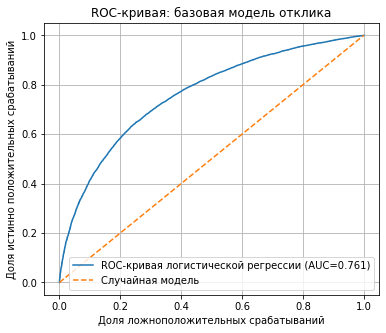

In [35]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_ho, p_ho)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC-кривая логистической регрессии (AUC={roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Случайная модель")
plt.xlabel("Доля ложноположительных срабатываний")
plt.ylabel("Доля истинно положительных срабатываний")
plt.title("ROC-кривая: базовая модель отклика")
plt.grid(True)
plt.legend()
plt.show()

In [27]:
def fit_t_learner(df_part: pd.DataFrame, model_type: str = "lr"):
    treated = df_part[df_part["treatment_flg"] == 1].copy()
    control = df_part[df_part["treatment_flg"] == 0].copy()

    X_t = treated.drop(columns=DROP_COLS + ["treatment_flg"], errors="ignore")
    y_t = treated["target"].astype(int)

    X_c = control.drop(columns=DROP_COLS + ["treatment_flg"], errors="ignore")
    y_c = control["target"].astype(int)

    pre = make_preprocessor(pd.concat([X_t, X_c], axis=0))

    if model_type == "xgb" and HAS_XGB:
        base = XGBClassifier(
            n_estimators=500,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_lambda=1.0,
            random_state=RANDOM_STATE,
            eval_metric="logloss",
            n_jobs=4,
        )
    else:
        base = LogisticRegression(max_iter=2000, n_jobs=4)

    m_t = Pipeline(steps=[("pre", pre), ("model", base)])

    # копия модели для контрольной группы
    base2 = base.__class__(**base.get_params()) if hasattr(base, "get_params") else LogisticRegression(max_iter=2000, n_jobs=4)
    m_c = Pipeline(steps=[("pre", pre), ("model", base2)])

    m_t.fit(X_t, y_t)
    m_c.fit(X_c, y_c)

    return m_t, m_c


def predict_uplift(m_t, m_c, df_part: pd.DataFrame) -> np.ndarray:
    X = df_part.drop(columns=DROP_COLS + ["treatment_flg"], errors="ignore")
    p1 = m_t.predict_proba(X)[:, 1]
    p0 = m_c.predict_proba(X)[:, 1]
    return p1 - p0


m_t, m_c = fit_t_learner(tr, model_type="xgb")
uplift_ho = predict_uplift(m_t, m_c, ho)

print("uplift_ho stats:", np.min(uplift_ho), np.mean(uplift_ho), np.max(uplift_ho))



uplift_ho stats: -0.2596732736152958 0.031166483896594373 0.7860700484076156


=== 3.2 Uplift metrics (holdout) ===
top 5%: uplift@k = 0.047348
top 10%: uplift@k = 0.058277
top 20%: uplift@k = 0.052459
top 30%: uplift@k = 0.044800
top 50%: uplift@k = 0.040655
Qini coefficient: 404.833788


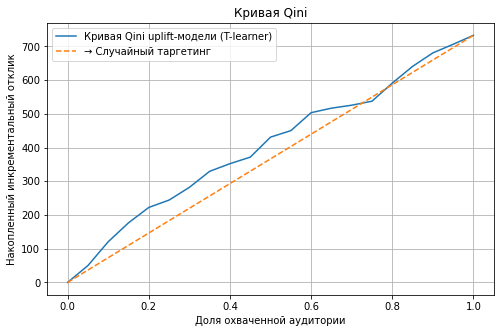

In [39]:
def uplift_at_k(uplift: np.ndarray, treatment: np.ndarray, y: np.ndarray, k_fracs=(0.05, 0.1, 0.2, 0.3, 0.5)):
    order = np.argsort(-uplift)
    n = len(y)
    out = {}
    for kf in k_fracs:
        k = max(1, int(round(n * kf)))
        idx = order[:k]
        t = treatment[idx]
        yy = y[idx]
        rt = yy[t == 1].mean() if np.any(t == 1) else 0.0
        rc = yy[t == 0].mean() if np.any(t == 0) else 0.0
        out[kf] = float(rt - rc)
    return out


def qini_curve(uplift: np.ndarray, treatment: np.ndarray, y: np.ndarray, n_bins: int = 20):
    order = np.argsort(-uplift)
    bins = np.array_split(order, n_bins)

    treated_total = 0
    control_total = 0
    treated_resp = 0
    control_resp = 0

    x = []
    q = []
    n = len(y)

    for b in bins:
        t = treatment[b]
        yy = y[b]

        treated_total += int((t == 1).sum())
        control_total += int((t == 0).sum())
        treated_resp += int(yy[t == 1].sum())
        control_resp += int(yy[t == 0].sum())

        expected_control_on_treated = (treated_total * (control_resp / control_total)) if control_total > 0 else 0.0
        inc = treated_resp - expected_control_on_treated

        x.append((treated_total + control_total) / n)
        q.append(inc)

    x = np.array([0.0] + x)
    q = np.array([0.0] + q)
    return x, q


def qini_coefficient(x: np.ndarray, q: np.ndarray) -> float:
    return float(np.trapz(q, x))


T_ho = ho["treatment_flg"].astype(int).to_numpy()
Y_ho = ho["target"].astype(int).to_numpy()

u_at_k = uplift_at_k(uplift_ho, T_ho, Y_ho)
x_q, q_q = qini_curve(uplift_ho, T_ho, Y_ho, n_bins=20)
qini = qini_coefficient(x_q, q_q)

print("=== 3.2 Uplift metrics (holdout) ===")
for kf, v in u_at_k.items():
    print(f"top {int(kf*100)}%: uplift@k = {v:.6f}")
print(f"Qini coefficient: {qini:.6f}")

plt.figure(figsize=(8, 5))
plt.plot(x_q, q_q, label="Кривая Qini uplift-модели (T-learner)")
plt.plot([0, 1], [0, q_q[-1]], linestyle="--", label="→ Случайный таргетинг")
plt.xlabel("Доля охваченной аудитории")
plt.ylabel("Накопленный инкрементальный отклик")
plt.title("Кривая Qini")
plt.grid(True)
plt.legend()
plt.show()


In [29]:
uplift_test = predict_uplift(m_t, m_c, df_test)

submit = pd.DataFrame({
    "client_id": df_test["client_id"].astype(str),
    "uplift_score": uplift_test
})

submit.to_csv("uplift_predictions.csv", index=False)
print("Saved: uplift_predictions.csv")
submit.head()


Saved: uplift_predictions.csv


,client_id,uplift_score
0,a9a604ed6e,0.030561
1,ebd7360016,0.039627
2,908cd9b8e8,0.015743
3,dceb8ce861,0.179831
4,f4f0ac6b06,0.041702


=== Qini comparison (holdout) ===
Qini (uplift targeting):  404.833788
Qini (response targeting): 317.227788


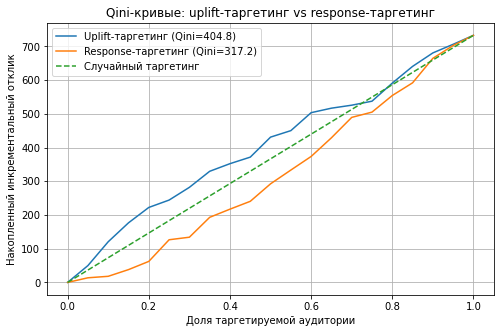

In [40]:
# --- 3.2 Comparison: Qini uplift vs response (holdout) ---

T_ho = ho["treatment_flg"].astype(int).to_numpy()
Y_ho = ho["target"].astype(int).to_numpy()

# 1) Qini для uplift-таргетинга: сортируем по uplift_ho
x_upl, q_upl = qini_curve(uplift_ho, T_ho, Y_ho, n_bins=20)
qini_upl = qini_coefficient(x_upl, q_upl)

# 2) Qini для response-таргетинга: сортируем по вероятности отклика p_ho
# (это не uplift-score, но это baseline-стратегия, и мы оцениваем её через те же uplift-метрики)
x_rsp, q_rsp = qini_curve(p_ho, T_ho, Y_ho, n_bins=20)
qini_rsp = qini_coefficient(x_rsp, q_rsp)

print("=== Qini comparison (holdout) ===")
print(f"Qini (uplift targeting):  {qini_upl:.6f}")
print(f"Qini (response targeting): {qini_rsp:.6f}")

# 3) График
plt.figure(figsize=(8, 5))
plt.plot(x_upl, q_upl, label=f"Uplift-таргетинг (Qini={qini_upl:.1f})")
plt.plot(x_rsp, q_rsp, label=f"Response-таргетинг (Qini={qini_rsp:.1f})")
plt.plot([0, 1], [0, q_upl[-1]], linestyle="--", label="Случайный таргетинг")
plt.xlabel("Доля таргетируемой аудитории")
plt.ylabel("Накопленный инкрементальный отклик")
plt.title("Qini-кривые: uplift-таргетинг vs response-таргетинг")
plt.grid(True)
plt.legend()
plt.show()


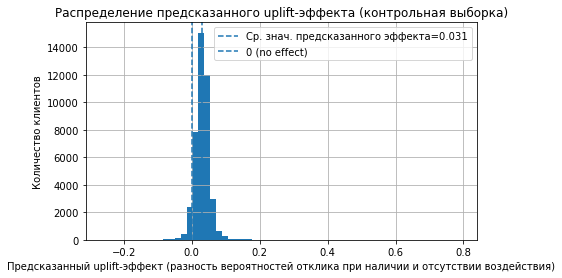

In [38]:
plt.figure(figsize=(7, 4))
plt.hist(uplift_ho, bins=60)
plt.axvline(np.mean(uplift_ho), linestyle="--", label=f"Ср. знач. предсказанного эффекта={np.mean(uplift_ho):.3f}")
plt.axvline(0.0, linestyle="--", label="0 (no effect)")
plt.xlabel("Предсказанный uplift-эффект (разность вероятностей отклика при наличии и отсутствии воздействия)")
plt.ylabel("Количество клиентов")
plt.title("Распределение предсказанного uplift-эффекта (контрольная выборка)")
plt.grid(True)
plt.legend()
plt.show()

SyntaxError: invalid syntax (<ipython-input-41-c1757c0aafc1>, line 1)